In [4]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

import GPy

In [5]:
def plot_with_sigma(x_train, y_train, x, y, sigma, label):
    pyplot.plot(x, y, label=label)
    pyplot.fill_between(x.ravel(), y.ravel() - 2 * sigma.ravel(), y.ravel() + 2 * sigma.ravel(), alpha=0.2)
    pyplot.plot(x_train, y_train, 'om', markersize=8, label='Data')
    pyplot.legend()

In [33]:
def f(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)  


def get_new_point(model):
    x_grid = np.linspace(0, 1, 200).reshape(-1, 1)

    prediction, std = model.predict(x_grid, return_std=True)
    
    new_point_index = np.argmax(std)
    x_new = x_grid[new_point_index]
    max_variance = std[new_point_index]
    return x_new, max_variance


def plot(x_train, y_train, model, x_new, max_variance):
    x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
    y_grid = f(x_grid)

    prediction, std = model.predict(x_grid, return_std=True)

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(x_train, y_train, 'or', markersize=8, label='Training set')
    pyplot.plot(x_grid, y_grid, '-k', linewidth=2, label='True function')
    pyplot.plot(x_grid, prediction, '--b', linewidth=2, label='Approximation')
    pyplot.plot(x_grid, std - 15, '-g', linewidth=2, label='Predicted error')
    pyplot.plot(x_new, max_variance - 15, 'og', markersize=10, label='New point')
    pyplot.ylim([-15, 20])
    pyplot.legend(loc='best')    

In [4]:
np.random.seed(239)

x_train = np.random.rand(4, 1)
y_train = f(x_train)

# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e1))
# model = GaussianProcessRegressor(kernel=kernel, normalize_y=True)


# for i in xrange(6):
#     model.fit(x_train, y_train)
#     x_new, max_variance = get_new_point(model)
#     plot(x_train, y_train, model, x_new, max_variance)
#     pyplot.show()
    
#     x_train = np.vstack([x_train, x_new.reshape(-1, 1)])
#     y_train = np.vstack([y_train, f(x_new).reshape(-1, 1)])

In [5]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

<Container object of 3 artists>

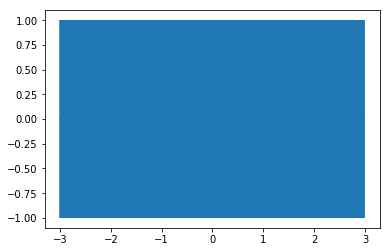

In [6]:
theta = [1, 10]
sigma_0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
pyplot.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)

In [7]:
sigma_1 = exponential_cov(x_train.ravel(), x_train.ravel(), theta)

def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new
 
x_pred = np.linspace(0, 1, 1000)
predictions = [predict(i, x_train.ravel(), exponential_cov, theta, sigma_1, y_train.ravel()) for i in x_pred]

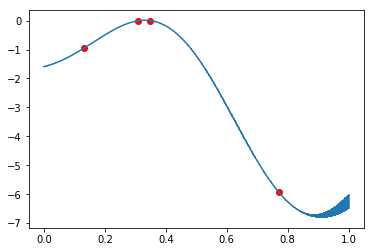

In [8]:
y_pred, sigmas = np.transpose(predictions)
pyplot.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
pyplot.plot(x_train, y_train, "ro")

In [10]:
N = 50
noise_var = 0.05

np.random.seed(1)
X = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)


Name : GP regression
Objective : 44.3901260937
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   1.58160142456  |      +ve      |        
  rbf.lengthscale          |  0.912346257959  |      +ve      |        
  Gaussian_noise.variance  |  0.160788301183  |      +ve      |        


 /home/yermek/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


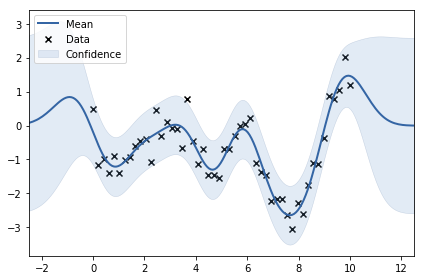

In [11]:
m_full = GPy.models.GPRegression(X,y)
m_full.optimize('bfgs')
m_full.plot()
print m_full

1.26**2 * RBF(length_scale=0.912) + WhiteKernel(noise_level=0.161)


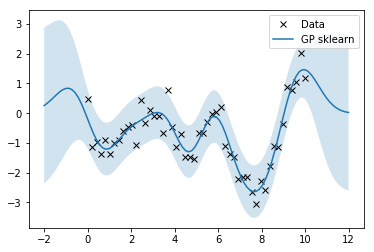

In [12]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-1, 1e2)) + WhiteKernel(noise_level=0.05)
model = GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                 kernel=kernel,
                                 n_restarts_optimizer=0, normalize_y=False,
                                 optimizer='fmin_l_bfgs_b', random_state=None)

model.fit(X, y)

print model.kernel_

x_grid = np.linspace(-2, 12, 100).reshape(-1, 1)
y_pred, sigma = model.predict(x_grid, return_std=True)
pyplot.plot(X, y, 'kx', label='Data')

pyplot.plot(x_grid, y_pred, label='GP sklearn')
pyplot.fill_between(x_grid.ravel(), y_pred.ravel() - 2 * sigma, y_pred.ravel() + 2 * sigma, alpha=0.2)
pyplot.legend()

In [13]:

x_grid.shape

(100, 1)

In [15]:
%matplotlib inline

x_train = np.random.rand(6, 1)
y_train = f(x_train)

model.fit(x_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.05),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

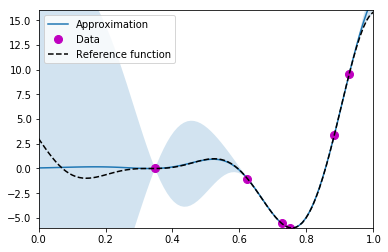

In [16]:
x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred, sigma = model.predict(x_grid, return_std=True)

pyplot.figure()
plot_with_sigma(x_train, y_train, x_grid, y_pred, sigma, 'Approximation')

y_true = f(x_grid)

pyplot.xlim([0, 1])
pyplot.ylim([-6, 16])
pyplot.plot(x_grid, y_true, '--k', label='Reference function')
pyplot.legend()

In [17]:
def plot_with_sigma(x_train, y_train, x, y, sigma, label):
    pyplot.plot(x, y, label=label)
    pyplot.fill_between(x.ravel(), y.ravel() - 2 * sigma.ravel(), y.ravel() + 2 * sigma.ravel(), alpha=0.2)
    pyplot.plot(x_train, y_train, 'om', markersize=8, label='Data')
    pyplot.legend()

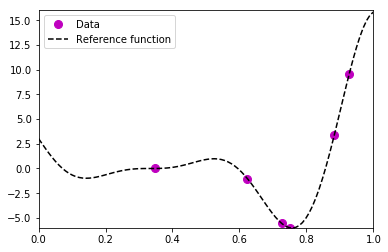

In [18]:
pyplot.figure()
pyplot.plot(x_train, y_train, 'om', markersize=8, label='Data')
pyplot.plot(x_grid, y_true, '--k', label='Reference function')

pyplot.xlim([0, 1])
pyplot.ylim([-6, 16])
pyplot.legend()

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
sys.path.insert(0, "../../..")

import pymc3 as pm
import seaborn as sns

sns.set(style='white', palette='deep', color_codes=True)


In [20]:
np.random.seed(1)

# Number of training points
n = 30
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * np.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
K_stable = K + 1e-12 * np.eye(n)

# Observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())

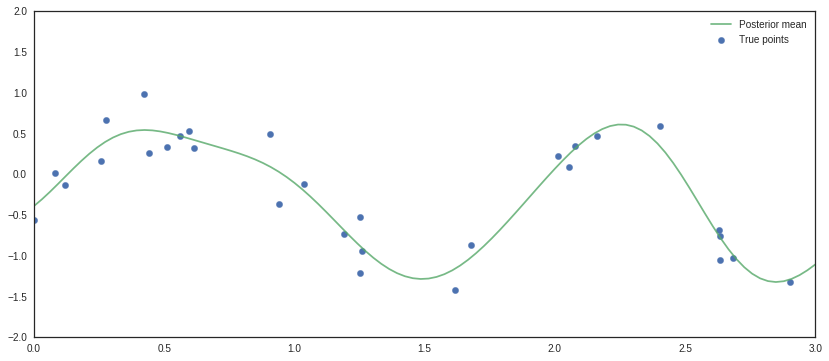

In [21]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

In [22]:
with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    f_sample = pm.Flat('f_sample', shape=(n, ))

    # Likelihood
    y = pm.MvNormal('y', observed=f, mu=f_sample, cov=noise * tt.eye(n), shape=n)

    # Interpolate function values using noisy covariance matrix
    L = tt.slinalg.cholesky(K_noise)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);

# GPy

## Sampling from posterior

 /home/yermek/.local/lib/python2.7/site-packages/GPy/core/gp.py:492: RuntimeWarning:covariance is not positive-semidefinite.


<IPython.core.display.Javascript object>


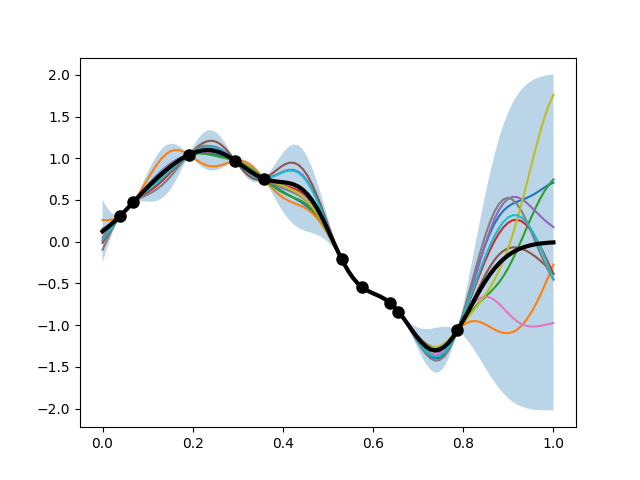

In [3]:
import GPy
import numpy as np

np.random.seed(17)
sample_size = 10
X = np.random.uniform(0, 1., (sample_size, 1))
Y = np.sin(2 * np.pi * X) + np.random.randn(sample_size, 1)*0.05

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X,Y,kernel, noise_var=1e-10)

model.optimize()

testX = np.linspace(0, 1, 100).reshape(-1, 1)
posteriorTestY = model.posterior_samples_f(testX, full_cov=True, size=10)
simY, simMse = model.predict(testX)

pyplot.figure()
pyplot.plot(testX, posteriorTestY)
pyplot.plot(X, Y, 'ok', markersize=8)
pyplot.fill_between(testX.ravel(), (simY - 3 * simMse ** 0.5).ravel(), (simY + 3 * simMse ** 0.5).ravel(), alpha=0.3)
#plt.plot(testX, simY + 3 * simMse ** 0.5, '--g')
pyplot.plot(testX, simY, '-k', linewidth=3)

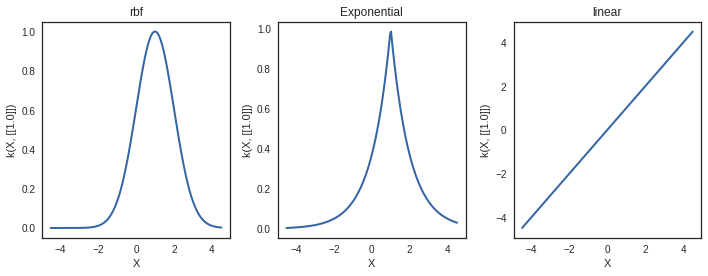

In [24]:
figure, axes = pyplot.subplots(1, 3, figsize=(10, 4), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Linear(1)]
models = []
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=1)
    a.set_title(k.name.replace('_', ' '))
    models.append(GPy.models.GPRegression(X, Y, k, noise_var=1e-10))
    models[-1].optimize()

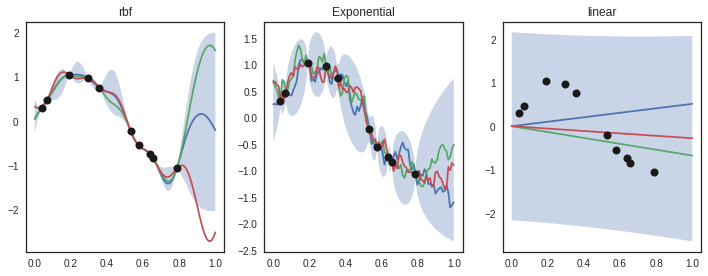

In [25]:
figure, axes = pyplot.subplots(1, 3, figsize=(10, 4), tight_layout=True)

for m, a in zip(models, axes.flatten()):
    posteriorTestY = m.posterior_samples_f(testX, full_cov=True, size=3)
    simY, simMse = m.predict(testX)

    a.set_title(m.kern.name)
    a.plot(testX, posteriorTestY)
    a.plot(X, Y, 'ok', markersize=8)
    a.fill_between(testX.ravel(), (simY - 3 * simMse ** 0.5).ravel(), (simY + 3 * simMse ** 0.5).ravel(), alpha=0.3)

In [ ]:
model.kern.name

In [ ]:
np.random.seed(239)

x_train = np.random.rand(4, 1)
y_train = f(x_train)

# GPy

* Специальная библиотека для построения ГП моделей
* Большое количество различных ковариационных функций
* Различные наработки для построения ГП на больших выборках
* Удобна в использовании
* Развивается


In [ ]:
import GPy
N = 50
noise_var = 0.05

np.random.seed(1)
x_train = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y_train = np.random.multivariate_normal(np.zeros(N), k.K(x_train) + np.eye(N) * np.sqrt(noise_var)).reshape(-1,1)

In [ ]:
import GPy

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=0.1)
model = GPy.models.GPRegression(x_train, y_train, kernel)
model.optimize()
model.plot()

# GPflow

* GPy, но с использованием TensorFlow
* Все возможности GPy
* Проста в использовании
* Плохая документация

In [ ]:
import GPflow

kernel = GPflow.kernels.RBF(input_dim=1, variance=1., lengthscales=0.1)
model = GPflow.gpr.GPR(x_train, y_train, kern=kernel)
model.optimize()

x = np.linspace(0, 10, 100).reshape(-1, 1)
y, sigma = model.predict_y(x)
pyplot.figure()
plot_with_sigma(x_train, y_train, x, y, np.sqrt(sigma), 'GPflow')
pyplot.show()

# PyMC3

* Мощный инструмент для построения вероятностных моделей
* Использует theano
* Много различных методов семплирования
* Необходимо разбираться в вероятностных моделях
* => Плохо подходит для построения ГП моделей


In [ ]:
import pymc3 as pm
import theano.tensor as tt

# define kernel
cov = pm.gp.cov.ExpQuad(1, 0.3)
K = cov(x_train)
K_s = cov(x_train, x)
K_noise = K + 0.05 * np.eye(N) + 1e-12 * np.eye(N)

with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    f_sample = pm.Flat('f_sample', shape=(N, ))

    # Likelihood
    y = pm.MvNormal('y', observed=y_train, mu=f_sample, cov=0.05 * tt.eye(N), shape=N)

    # Interpolate function values using noisy covariance matrix
    L = tt.slinalg.cholesky(K_noise)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_noise)
    trace = pm.sample(2000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

In [ ]:
# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
post_mean = np.dot(K_s.T.eval(), alpha)

fig, ax = pyplot.subplots()
for idx in np.random.randint(1000, 2000, 500):
    ax.plot(x, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(x_train, y_train, s=40, color='k', label='Data');
ax.plot(x, post_mean, color='g', alpha=0.8, label='Predictions');
ax.legend();

# Scikit-learn

* Популярная библиотека для анализа данных и машинного обучения
* Гауссовские процессы есть, но урезанные
* Сложнее настраивать параметры, легче переобучиться

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e1)) + WhiteKernel(noise_level=0.05)
model = GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                 kernel=kernel,
                                 n_restarts_optimizer=0, normalize_y=False,
                                 optimizer='fmin_l_bfgs_b', random_state=None)
model.fit(x_train, y_train)


x = np.linspace(0, 10, 100).reshape(-1, 1)
y, sigma = model.predict(x, return_std=True)
pyplot.figure()
plot_with_sigma(x_train, y_train, x, y, sigma, 'GP sklearn')
pyplot.show()

# Байсовская оптимизация

In [ ]:
def f(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)  


def lower_confidence_bound(x, model, coefficient=2):
    prediction, std = model.predict(x, return_std=True)
    return prediction.ravel() - coefficient * std.ravel()

def get_new_point(model):
    x_grid = np.linspace(0, 1, 200).reshape(-1, 1)

    lcb = lower_confidence_bound(x_grid, model, 2)

    new_point_index = np.argmin(lcb)
    x_new = x_grid[new_point_index]
    lcb = lcb[new_point_index]
    return x_new, lcb


def plot(x_train, y_train, model, x_new, lcb):
    x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
    y_grid = f(x_grid)

    prediction, std = model.predict(x_grid, return_std=True)
    prediction = prediction.ravel()
    std = std.ravel()

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(x_train, y_train, 'or', markersize=8, label='Training set')
    pyplot.plot(x_grid, y_grid, '--b', linewidth=2, label='True function')
    pyplot.plot(x_grid, prediction, '-k', linewidth=2, label='Approximation')
    pyplot.fill_between(x_grid.ravel(), prediction - 2 * std, prediction + 2 * std, alpha=0.3)
    pyplot.plot(x_new, lcb, 'og', markersize=10, label='New point')
    pyplot.ylim([-15, 20])
    pyplot.legend(loc='best')

def optimization_step(x_train, y_train, model):
    model.fit(x_train, y_train)

    x_new, lcb = get_new_point(model)
    plot(x_train, y_train, model, x_new, lcb)
    pyplot.show()
    
    x_train = np.vstack([x_train, x_new.reshape(-1, 1)])
    y_train = np.vstack([y_train, f(x_new).reshape(-1, 1)])
    return x_train, y_train

In [ ]:
np.random.seed(239)

x_train = np.array([0.0, 0.58, 0.38, 0.95]).reshape(-1, 1)
y_train = f(x_train)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-1, 1e1))
model = GaussianProcessRegressor(kernel=kernel, normalize_y=True)


x_train, y_train = optimization_step(x_train, y_train, model)

In [ ]:
x_train, y_train = optimization_step(x_train, y_train, model)

# Heaviside function

<IPython.core.display.Javascript object>


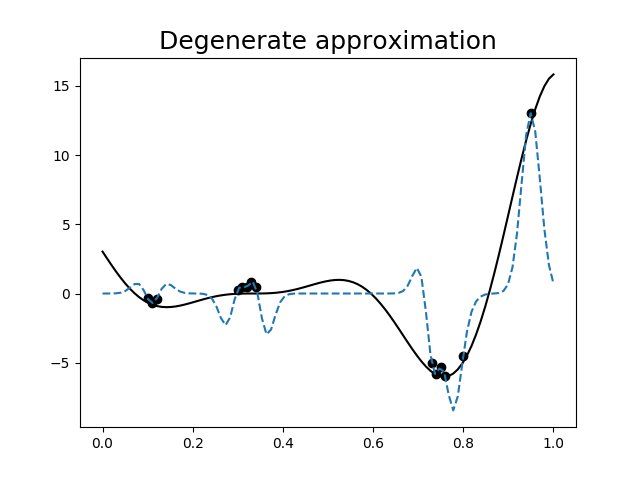

In [155]:
# x = np.linspace(0, 1, 10).reshape(-1, 1)
# x = np.random.rand(10, 1)
x = np.array([0.1, 0.11, 0.12, 0.3, 0.31, 0.32, 0.33, 0.34, 0.73, 0.74, 0.75, 0.76, 0.8, 0.95]).reshape(-1, 1)
y = f(x) + np.random.rand(x.shape[0], 1)

kernel = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=0.1)
# kernel = GPy.kern.Exponential(1)#(input_dim=1, variance=1., lengthscale=0.1)
#mf = GPy.mappings.Constant(1, 1)
model = GPy.models.GPRegression(x, y, kernel, noise_var=1e-10)#, mean_function=mf)
model.optimize()

x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
y_grid = f(x_grid)

pr, std = model.predict(x_grid)
pyplot.figure()
pyplot.title('Degenerate approximation', fontsize=18)
pyplot.plot(x_grid, y_grid, '-k')
pyplot.plot(x, y, 'ok')
pyplot.plot(x_grid, pr, '--')
pyplot.show()


<IPython.core.display.Javascript object>


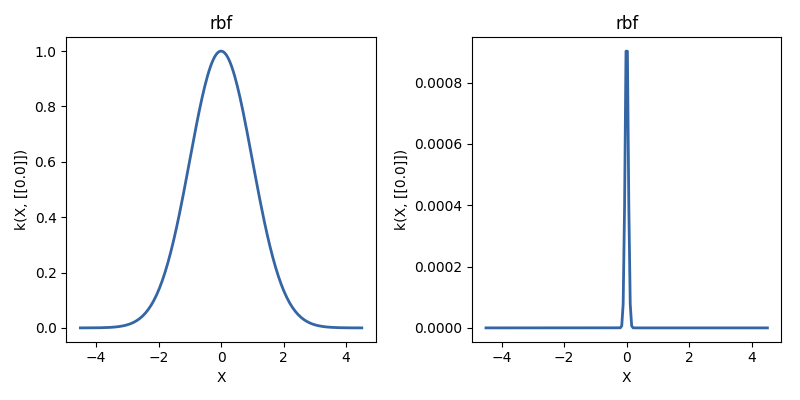

In [165]:
figure, axes = pyplot.subplots(1, 2, figsize=(8, 4), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.RBF(1, 0.001, 0.05)]#, GPy.kern.Exponential(1), GPy.kern.Linear(1)]
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=0)
    a.set_title(k.name.replace('_', ' '))